In [ ]:
#import the needed Libraries

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from PIL import Image
import pandas as pd

from IPython import display
import cv2
import pickle


import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the DataFrame which includes the path and label
df_data = pd.read_csv('/content/drive/MyDrive/AML/Challenge1/dataset/train.csv')  # Adjust path as needed
data_dir = '/content/drive/MyDrive/AML/Challenge1/dataset/train/train/'

# Filter out images without a cactus
df_data = df_data[df_data['has_cactus'] == 1]

df_data.shape

(13136, 2)

In [ ]:
df_data

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17493,ffeafc3bd716a83bc93014fdb0ef53fa.jpg,1
17494,ffed5c4d70e58d53fbba6e92570371ef.jpg,1
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1


In [ ]:
# @title done in my machine bc google badwith disk sucks

# images = []
# labels = []

# # Load images and their labels
# for img_name, label in tqdm(df_data.values, total=df_data.shape[0], desc="Loading images"):
#     img_path = os.path.join(data_dir, img_name)
#     if os.path.exists(img_path):  # Check if the image file exists
#         image = cv2.imread(img_path)
#         if image is not None:
#             images.append(image)
#             labels.append(label)
#         else:
#             print(f"Failed to load image: {img_path}")  # Feedback if an image cannot be loaded
#     else:
#         print(f"File not found: {img_path}")  # Feedback if file path is incorrect

# # Convert lists to numpy arrays
# images = np.array(images)

# # Normalize pixel values to be between 0 and 1
# images = images.astype('float32') / 255

In [ ]:
with open('/content/drive/MyDrive/AML/Challenge1/dataset/images_0.pickle', 'rb') as f:
    images_0 = pickle.load(f)
images_0=images_0[:655]

In [ ]:
# with open('/content/drive/MyDrive/AML/Challenge1/dataset/images.pickle', 'rb') as f:
#     images = pickle.load(f)
with open('/content/drive/MyDrive/AML/Challenge1/dataset/images.pickle', 'rb') as f:
    images = pickle.load(f)


# Shuffle the dataset
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]

# Split into training and test sets
train_images, test_images = np.split(images, [int(0.8 * len(images))])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(len(test_images)).batch(64)


# # Calculate split indices
# train_size = int(0.7 * len(images))
# validation_size = int(0.15 * len(images)) + train_size

# # Split into training, validation, and test sets
# train_images = images[:train_size]
# validation_images = images[train_size:validation_size]
# test_images = images[validation_size:]

# # Create TensorFlow datasets
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(64)
# validation_dataset = tf.data.Dataset.from_tensor_slices(validation_images).shuffle(len(validation_images)).batch(64)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(len(test_images)).batch(64)

# # Check the size of each dataset
# print("Training set size: ", len(train_images))
# print("Validation set size: ", len(validation_images))
# print("Testing set size: ", len(test_images))

In [ ]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [ ]:
#create a write
writer = tf.summary.create_file_writer('./new_loss')

In [ ]:
#@title with dropout

# class CVAE(tf.keras.Model):
#     def __init__(self, latent_dim, dropout_rate=0.5):  # Adding a dropout_rate parameter with a default of 0.5
#         super(CVAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.inference_net = tf.keras.Sequential(
#           [
#               tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
#               tf.keras.layers.Conv2D(
#                   filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
#               tf.keras.layers.Dropout(dropout_rate),  # Dropout after convolution
#               tf.keras.layers.Conv2D(
#                   filters=64, kernel_size=3, strides=(1, 1), activation='relu'),
#               tf.keras.layers.Dropout(dropout_rate),  # Dropout after convolution
#               tf.keras.layers.Conv2D(
#                   filters=128, kernel_size=3, strides=(1, 1), activation='relu'),
#               tf.keras.layers.Flatten(),
#               tf.keras.layers.Dense(latent_dim + latent_dim),
#           ]
#         )

#         self.generative_net = tf.keras.Sequential(
#             [
#               tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
#               tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
#               tf.keras.layers.Dropout(dropout_rate),  # Dropout after dense layer
#               tf.keras.layers.Reshape(target_shape=(16,16, 32)),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=64,
#                   kernel_size=3,
#                   strides=(2, 2),
#                   padding="SAME",
#                   activation='relu'),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=64,
#                   kernel_size=3,
#                   strides=(1, 1),
#                   padding="SAME",
#                   activation='relu'),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=128,
#                   kernel_size=3,
#                   strides=(1, 1),
#                   padding="SAME",
#                   activation='relu'),
#               tf.keras.layers.Conv2DTranspose(
#                   filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid'),
#             ]
#         )
#     @tf.function
#     def sample(self, eps=None):
#         if eps is None:
#             eps = tf.random.normal(shape=(64, self.latent_dim))
#         return self.decode(eps, apply_sigmoid=True)

#     def encode(self, x):   #encode the images into the latent space
#         mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
#         return mean, logvar

#     #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
#     #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it
#     #by the latent distribution's variance 'rho'.

#     def reparameterize(self, mean, logvar):
#         eps = tf.random.normal(shape=mean.shape)
#         return eps * tf.exp(logvar * .5) + mean

#     def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
#         logits = self.generative_net(z)
#         if apply_sigmoid:
#             probs = tf.sigmoid(logits)
#             return probs
#         return logits


In [ ]:
#@title without dropout
#The Convolutional Variational Auto-Encoder Proper.
#Define the network class

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):   #latent_dim is the dimensional of the latent space
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),   #Note Input Image Size
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=128, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(16,16, 32)), #Note the strides formula!
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=128,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=3, kernel_size= 3, strides=(1, 1), padding="SAME", activation='sigmoid'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):   #encode the images into the latent space
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
    #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it
    #by the latent distribution's variance 'rho'.

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    kl_tolerance = 0.2
    #import pdb; pdb.set_trace()
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1, 2, 3]))
    kl_loss = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar),axis=1)
    kl_loss = tf.reduce_mean(tf.maximum(kl_loss, kl_tolerance * latent_dim))
    loss_sum = reconstruction_loss + kl_loss

    with writer.as_default():
        tf.summary.scalar('Graph of' + '_reconstruction_loss', reconstruction_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_kl_loss', kl_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_loss_sum',loss_sum, step=epoch)
        writer.flush()
    return loss_sum, reconstruction_loss, kl_loss

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, r_loss, kl_loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return r_loss, kl_loss

In [ ]:
# @tf.function
# def compute_loss(model, x):
#     #...
#     reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1, 2, 3]))
#     kl_loss = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
#     loss_sum = reconstruction_loss + kl_loss

#     #Compute additional metrics
#     mahalanobis_distance = tf.linalg.mahalanobis_distance(z, mean, logvar)
#     likelihood_ratio = tf.probability.likelihood_ratio(z, mean, logvar)
#     wasserstein_distance = tf.linalg.wasserstein_distance(z, mean, logvar)

#     return loss_sum, reconstruction_loss, kl_loss, mahalanobis_distance, likelihood_ratio, wasserstein_distance


In [ ]:
epochs = 100
latent_dim = 128#was 128 before
num_examples_to_generate = 12#was 12 before

In [ ]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [ ]:
model.built = True

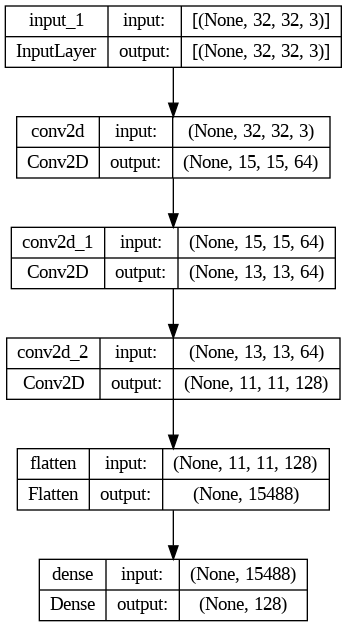

In [ ]:
from keras.utils import plot_model

# Assuming your model instance is named 'model'
# Plot the inference network
plot_model(model.inference_net, to_file='inference_net.png', show_shapes=True, show_layer_names=True)


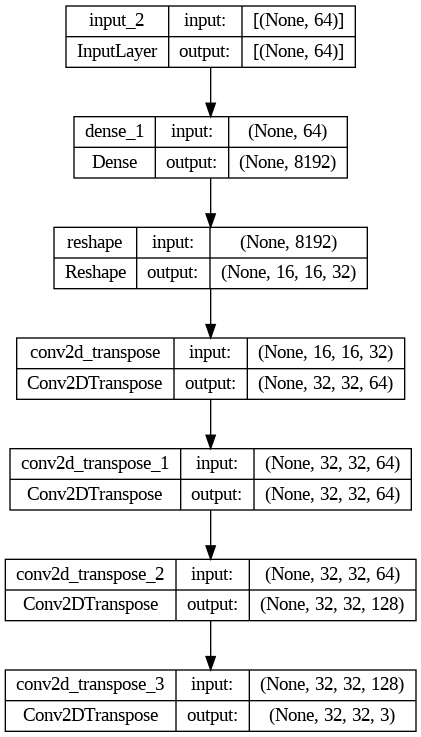

In [ ]:
# Plot the generative network
plot_model(model.generative_net, to_file='generative_net.png', show_shapes=True, show_layer_names=True)

In [ ]:
# def generate_and_save_images(model, epoch, test_input):
#     predictions = model.sample(test_input)
#     fig = plt.figure(figsize=(16,16))

#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0])
#         plt.axis('off')

#     # tight_layout minimizes the overlap between 2 sub-plots
#     plt.savefig('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/images/image_at_epoch__24vec{:04d}.png'.format(epoch))
#     plt.show()
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)  # Assuming this returns the images to plot

    plt.figure(figsize=(10, 10))  # Creating a figure large enough to hold all subplots

    # Ensure we do not attempt to plot more images than we have subplots for
    num_images = predictions.shape[0]
    max_images = 16  # As you seem to be setting up a 4x4 grid
    num_images = min(num_images, max_images)

    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0])  # Adjust indexing if needed based on data format
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/images/image_at_epoch_{}.png'.format(epoch))
    plt.show()


In [ ]:
def test_image(latent_dim,test_img):
    test_img = test_img.reshape(1,32,32,3)   #Note the Image size here
    model = CVAE(latent_dim)
    encod, logvar = model.encode(test_img)
    repar = model.reparameterize(encod, logvar)
    img = model.decode(repar)
    img *= 255.
    img = np.squeeze(img)
    return plt.imshow(img)

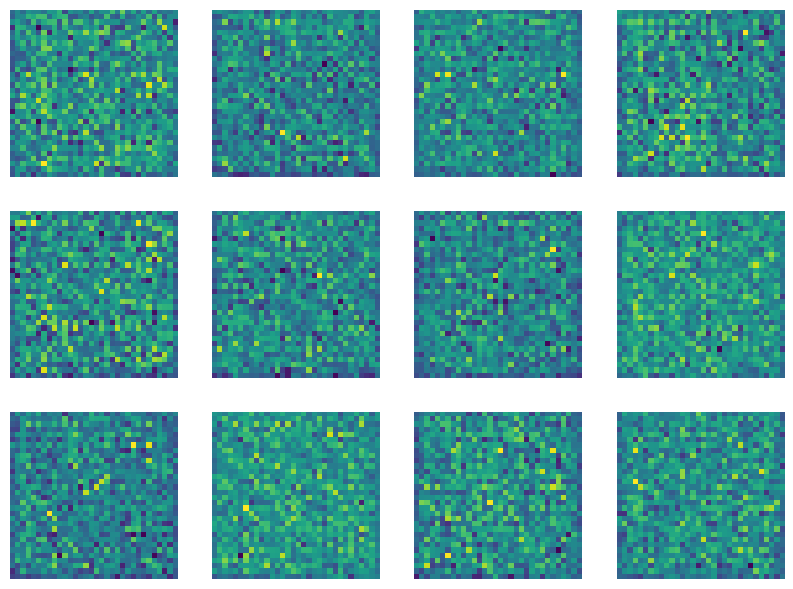

Epoch: 1, reconstruction_loss: 55.53657150268555, kl_loss: 13.376437187194824
Epoch: 1, Test set LOSS_sum: 58.104061126708984, reconstruction_loss: 44.89889907836914, kl_loss: 13.205150604248047
Checkpoint saved at Epoch 1: Improved reconstruction_loss and kl_loss.
Epoch: 2, reconstruction_loss: 44.13669204711914, kl_loss: 13.0549898147583
Epoch: 2, Test set LOSS_sum: 54.9868049621582, reconstruction_loss: 42.024749755859375, kl_loss: 12.962056159973145
Checkpoint saved at Epoch 2: Improved reconstruction_loss and kl_loss.
Epoch: 3, reconstruction_loss: 41.2816276550293, kl_loss: 13.005247116088867
Epoch: 3, Test set LOSS_sum: 53.350372314453125, reconstruction_loss: 40.316226959228516, kl_loss: 13.034146308898926
Checkpoint saved at Epoch 3: Improved reconstruction_loss and kl_loss.
Epoch: 4, reconstruction_loss: 39.6833381652832, kl_loss: 12.984525680541992
Epoch: 4, Test set LOSS_sum: 52.94169235229492, reconstruction_loss: 39.73790740966797, kl_loss: 13.203790664672852
Checkpoint s

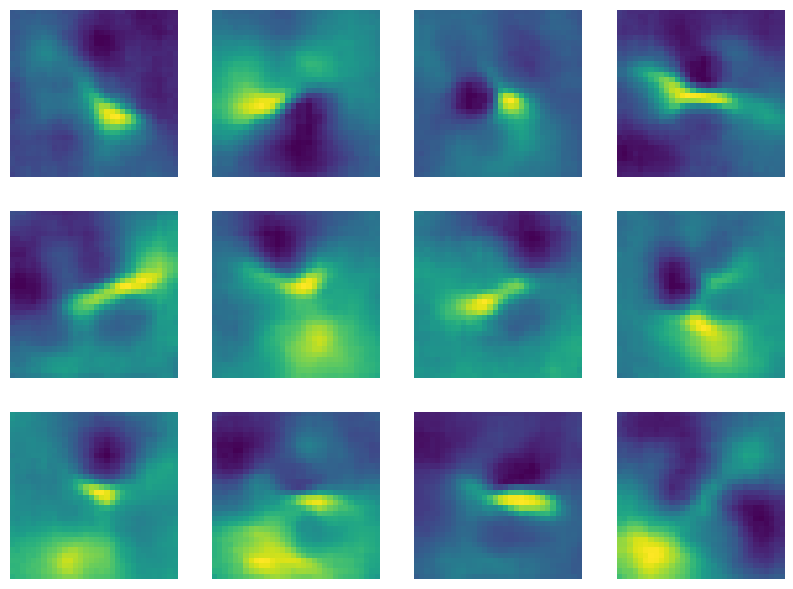

Epoch: 11, reconstruction_loss: 36.96889877319336, kl_loss: 13.09984302520752
Epoch: 11, Test set LOSS_sum: 49.55100631713867, reconstruction_loss: 36.46387481689453, kl_loss: 13.087127685546875
Checkpoint saved at Epoch 11: Improved reconstruction_loss and kl_loss.
Epoch: 12, reconstruction_loss: 36.608299255371094, kl_loss: 13.084931373596191
Epoch: 12, Test set LOSS_sum: 49.928977966308594, reconstruction_loss: 36.821895599365234, kl_loss: 13.10706901550293
Epoch: 13, reconstruction_loss: 36.321598052978516, kl_loss: 13.092637062072754
Epoch: 13, Test set LOSS_sum: 49.647705078125, reconstruction_loss: 36.44868850708008, kl_loss: 13.199005126953125
Checkpoint saved at Epoch 13: Improved reconstruction_loss and kl_loss.
Epoch: 14, reconstruction_loss: 36.07219314575195, kl_loss: 13.076485633850098
Epoch: 14, Test set LOSS_sum: 49.13473129272461, reconstruction_loss: 35.98509979248047, kl_loss: 13.149641990661621
Checkpoint saved at Epoch 14: Improved reconstruction_loss and kl_loss.


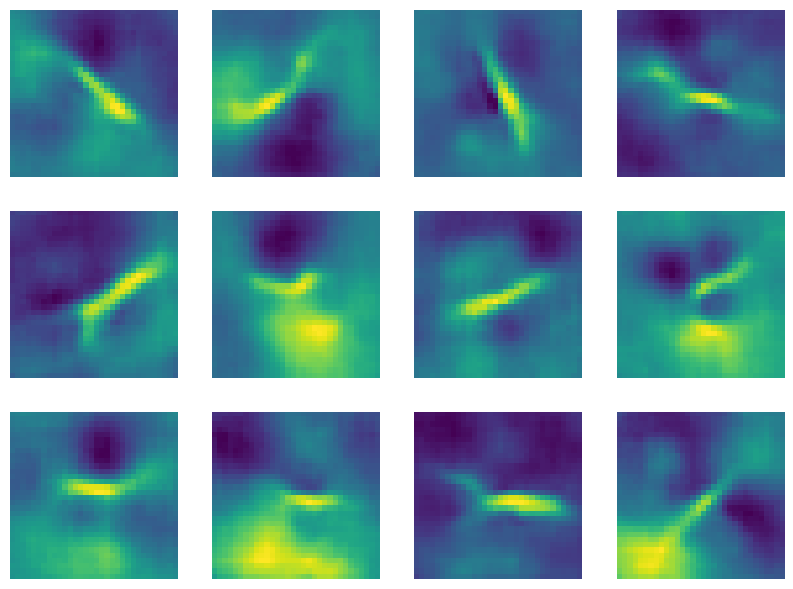

Epoch: 21, reconstruction_loss: 35.53804397583008, kl_loss: 13.102157592773438
Epoch: 21, Test set LOSS_sum: 48.75227737426758, reconstruction_loss: 35.70915222167969, kl_loss: 13.043129920959473
Epoch: 22, reconstruction_loss: 35.4990348815918, kl_loss: 13.097928047180176
Epoch: 22, Test set LOSS_sum: 48.69594955444336, reconstruction_loss: 35.49564743041992, kl_loss: 13.200298309326172
Checkpoint saved at Epoch 22: Improved reconstruction_loss and kl_loss.
Epoch: 23, reconstruction_loss: 35.41005325317383, kl_loss: 13.090729713439941
Epoch: 23, Test set LOSS_sum: 48.572731018066406, reconstruction_loss: 35.44306564331055, kl_loss: 13.129657745361328
Checkpoint saved at Epoch 23: Improved reconstruction_loss and kl_loss.
Epoch: 24, reconstruction_loss: 35.36886978149414, kl_loss: 13.096955299377441
Epoch: 24, Test set LOSS_sum: 48.27681350708008, reconstruction_loss: 35.252933502197266, kl_loss: 13.023883819580078
Checkpoint saved at Epoch 24: Improved reconstruction_loss and kl_loss.

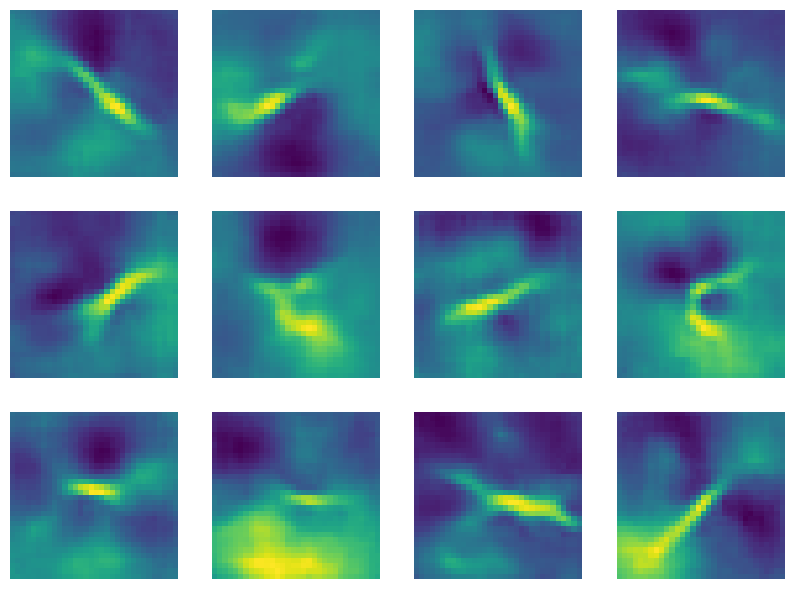

Epoch: 31, reconstruction_loss: 35.13389205932617, kl_loss: 13.11058235168457
Epoch: 31, Test set LOSS_sum: 48.31990051269531, reconstruction_loss: 35.31557083129883, kl_loss: 13.004316329956055
Epoch: 32, reconstruction_loss: 35.16522216796875, kl_loss: 13.1183443069458
Epoch: 32, Test set LOSS_sum: 49.068180084228516, reconstruction_loss: 35.92271041870117, kl_loss: 13.145463943481445
Epoch: 33, reconstruction_loss: 35.094783782958984, kl_loss: 13.09565544128418
Epoch: 33, Test set LOSS_sum: 48.18777084350586, reconstruction_loss: 35.02721405029297, kl_loss: 13.160557746887207
Epoch: 34, reconstruction_loss: 35.06637191772461, kl_loss: 13.09613037109375
Epoch: 34, Test set LOSS_sum: 48.49052047729492, reconstruction_loss: 35.31394577026367, kl_loss: 13.176567077636719
Epoch: 35, reconstruction_loss: 34.97404861450195, kl_loss: 13.099650382995605
Epoch: 35, Test set LOSS_sum: 48.144405364990234, reconstruction_loss: 35.09166717529297, kl_loss: 13.052736282348633
Epoch: 36, reconstruct

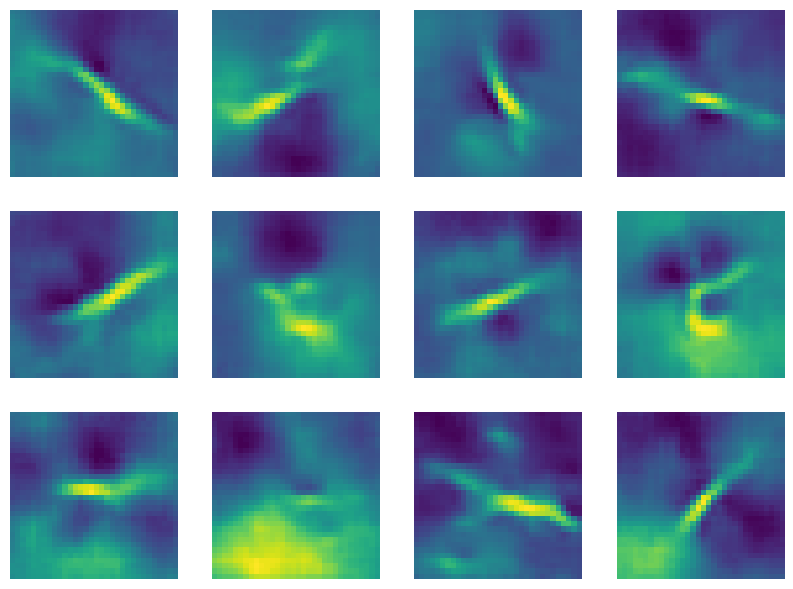

Epoch: 41, reconstruction_loss: 34.893489837646484, kl_loss: 13.10113525390625
Epoch: 41, Test set LOSS_sum: 48.521148681640625, reconstruction_loss: 35.2930908203125, kl_loss: 13.228047370910645
Epoch: 42, reconstruction_loss: 34.837989807128906, kl_loss: 13.109496116638184
Epoch: 42, Test set LOSS_sum: 48.150482177734375, reconstruction_loss: 34.82893753051758, kl_loss: 13.321547508239746
Checkpoint saved at Epoch 42: Improved reconstruction_loss and kl_loss.
Epoch: 43, reconstruction_loss: 34.781131744384766, kl_loss: 13.104338645935059
Epoch: 43, Test set LOSS_sum: 48.173126220703125, reconstruction_loss: 35.02737045288086, kl_loss: 13.145753860473633
Epoch: 44, reconstruction_loss: 34.85992431640625, kl_loss: 13.103231430053711
Epoch: 44, Test set LOSS_sum: 48.405906677246094, reconstruction_loss: 35.1884880065918, kl_loss: 13.217427253723145
Epoch: 45, reconstruction_loss: 34.776641845703125, kl_loss: 13.116168022155762
Epoch: 45, Test set LOSS_sum: 48.62806701660156, reconstruct

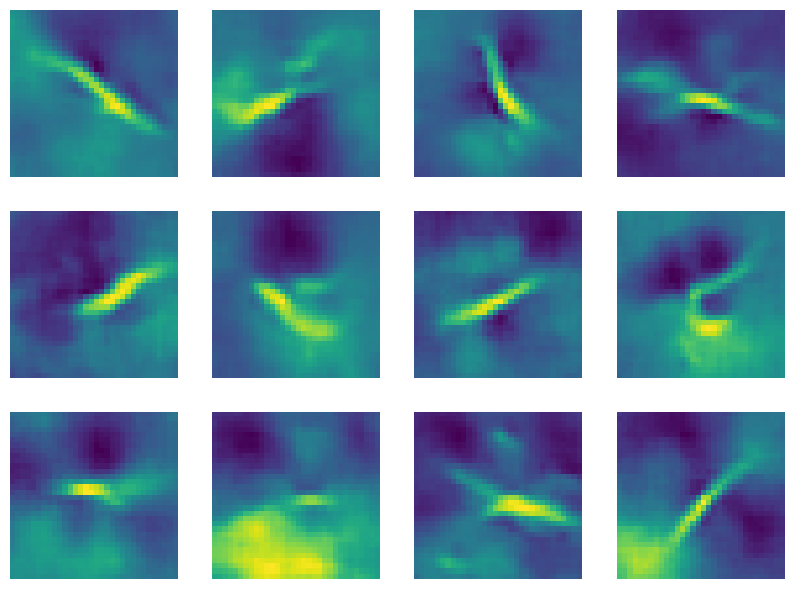

Epoch: 51, reconstruction_loss: 34.60591125488281, kl_loss: 13.133370399475098
Epoch: 51, Test set LOSS_sum: 48.91218566894531, reconstruction_loss: 35.69147491455078, kl_loss: 13.22071361541748
Epoch: 52, reconstruction_loss: 34.67977523803711, kl_loss: 13.11866569519043
Epoch: 52, Test set LOSS_sum: 47.933292388916016, reconstruction_loss: 34.82804489135742, kl_loss: 13.105246543884277
Epoch: 53, reconstruction_loss: 34.66565704345703, kl_loss: 13.13433837890625
Epoch: 53, Test set LOSS_sum: 48.47068786621094, reconstruction_loss: 35.164398193359375, kl_loss: 13.306294441223145
Epoch: 54, reconstruction_loss: 34.69194030761719, kl_loss: 13.127202987670898
Epoch: 54, Test set LOSS_sum: 48.165489196777344, reconstruction_loss: 34.96382522583008, kl_loss: 13.201664924621582
Epoch: 55, reconstruction_loss: 34.580196380615234, kl_loss: 13.119389533996582
Epoch: 55, Test set LOSS_sum: 48.09858703613281, reconstruction_loss: 34.915077209472656, kl_loss: 13.183510780334473
Epoch: 56, reconst

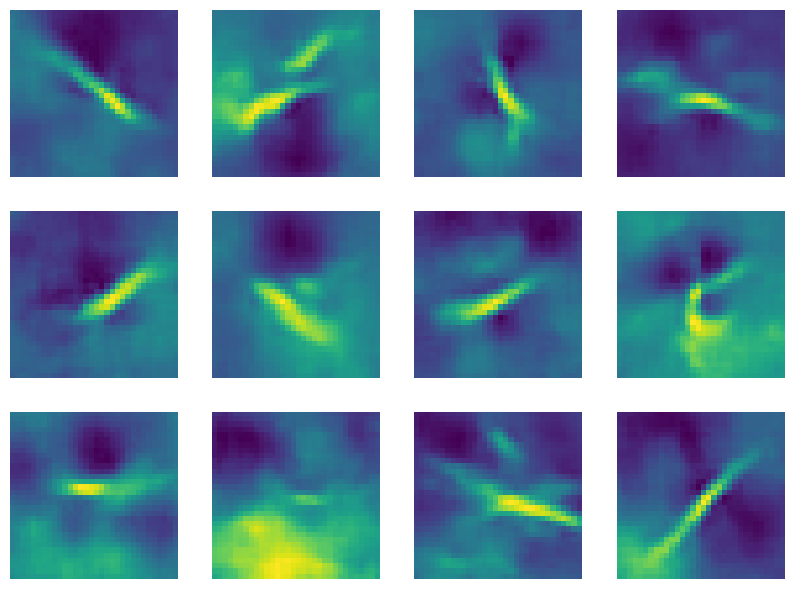

Epoch: 61, reconstruction_loss: 34.53687286376953, kl_loss: 13.147313117980957
Epoch: 61, Test set LOSS_sum: 48.07953643798828, reconstruction_loss: 34.85882568359375, kl_loss: 13.22071647644043
Epoch: 62, reconstruction_loss: 34.41992950439453, kl_loss: 13.139618873596191
Epoch: 62, Test set LOSS_sum: 48.19782257080078, reconstruction_loss: 34.971473693847656, kl_loss: 13.226350784301758
Epoch: 63, reconstruction_loss: 34.402137756347656, kl_loss: 13.13949203491211
Epoch: 63, Test set LOSS_sum: 48.99702453613281, reconstruction_loss: 35.631752014160156, kl_loss: 13.365276336669922
Epoch: 64, reconstruction_loss: 34.466983795166016, kl_loss: 13.143820762634277
Epoch: 64, Test set LOSS_sum: 48.88077163696289, reconstruction_loss: 35.701873779296875, kl_loss: 13.1788969039917
Epoch: 65, reconstruction_loss: 34.40913772583008, kl_loss: 13.139001846313477
Epoch: 65, Test set LOSS_sum: 48.0843505859375, reconstruction_loss: 34.872886657714844, kl_loss: 13.211459159851074
Epoch: 66, reconstr

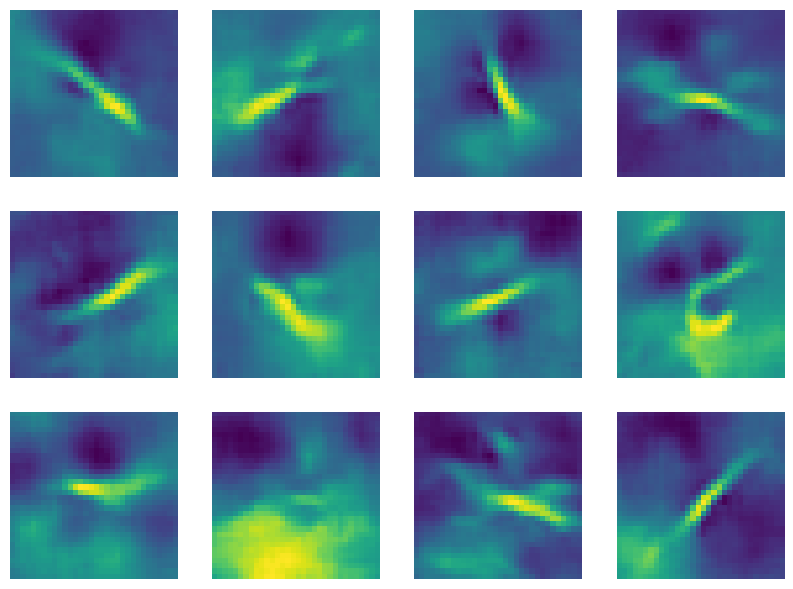

Epoch: 71, reconstruction_loss: 34.321624755859375, kl_loss: 13.157630920410156
Epoch: 71, Test set LOSS_sum: 48.08654022216797, reconstruction_loss: 34.81700897216797, kl_loss: 13.269523620605469
Epoch: 72, reconstruction_loss: 34.322723388671875, kl_loss: 13.150369644165039
Epoch: 72, Test set LOSS_sum: 48.43079376220703, reconstruction_loss: 35.1458740234375, kl_loss: 13.28492259979248
Epoch: 73, reconstruction_loss: 34.32988739013672, kl_loss: 13.160019874572754
Epoch: 73, Test set LOSS_sum: 48.0200309753418, reconstruction_loss: 34.54515838623047, kl_loss: 13.474876403808594
Epoch: 74, reconstruction_loss: 34.329933166503906, kl_loss: 13.155109405517578
Epoch: 74, Test set LOSS_sum: 48.292083740234375, reconstruction_loss: 35.14501953125, kl_loss: 13.147072792053223
Epoch: 75, reconstruction_loss: 34.29132080078125, kl_loss: 13.158734321594238
Epoch: 75, Test set LOSS_sum: 47.810791015625, reconstruction_loss: 34.65095901489258, kl_loss: 13.159828186035156
Epoch: 76, reconstructio

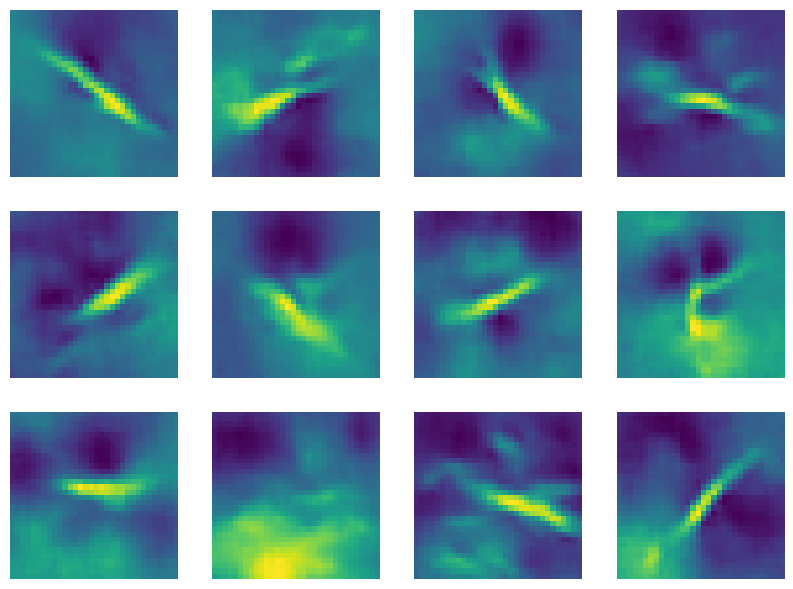

Epoch: 81, reconstruction_loss: 34.21559143066406, kl_loss: 13.153733253479004
Epoch: 81, Test set LOSS_sum: 47.789825439453125, reconstruction_loss: 34.653404235839844, kl_loss: 13.136418342590332
Epoch: 82, reconstruction_loss: 34.239070892333984, kl_loss: 13.163420677185059
Epoch: 82, Test set LOSS_sum: 48.24884033203125, reconstruction_loss: 34.9518928527832, kl_loss: 13.296943664550781
Epoch: 83, reconstruction_loss: 34.188026428222656, kl_loss: 13.160533905029297
Epoch: 83, Test set LOSS_sum: 48.00342559814453, reconstruction_loss: 34.6228141784668, kl_loss: 13.380610466003418
Epoch: 84, reconstruction_loss: 34.26447296142578, kl_loss: 13.17381477355957
Epoch: 84, Test set LOSS_sum: 47.95273971557617, reconstruction_loss: 34.823326110839844, kl_loss: 13.12940502166748
Epoch: 85, reconstruction_loss: 34.211997985839844, kl_loss: 13.166218757629395
Epoch: 85, Test set LOSS_sum: 48.28729248046875, reconstruction_loss: 35.2032585144043, kl_loss: 13.084028244018555
Epoch: 86, reconstr

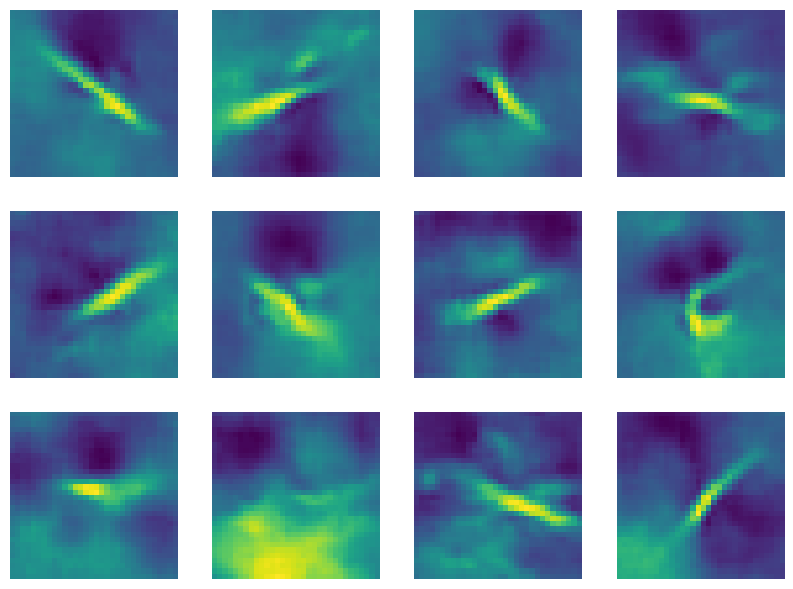

Epoch: 91, reconstruction_loss: 34.031593322753906, kl_loss: 13.189839363098145
Epoch: 91, Test set LOSS_sum: 47.889137268066406, reconstruction_loss: 34.76242446899414, kl_loss: 13.126710891723633
Epoch: 92, reconstruction_loss: 34.065345764160156, kl_loss: 13.183284759521484
Epoch: 92, Test set LOSS_sum: 47.95625686645508, reconstruction_loss: 34.68089294433594, kl_loss: 13.275362014770508
Epoch: 93, reconstruction_loss: 34.059410095214844, kl_loss: 13.176373481750488
Epoch: 93, Test set LOSS_sum: 48.68863296508789, reconstruction_loss: 35.3015251159668, kl_loss: 13.387107849121094
Epoch: 94, reconstruction_loss: 34.034461975097656, kl_loss: 13.187649726867676
Epoch: 94, Test set LOSS_sum: 48.14563751220703, reconstruction_loss: 34.93915557861328, kl_loss: 13.206490516662598
Epoch: 95, reconstruction_loss: 34.06517028808594, kl_loss: 13.192803382873535
Epoch: 95, Test set LOSS_sum: 48.470726013183594, reconstruction_loss: 35.13685989379883, kl_loss: 13.333867073059082
Epoch: 96, reco

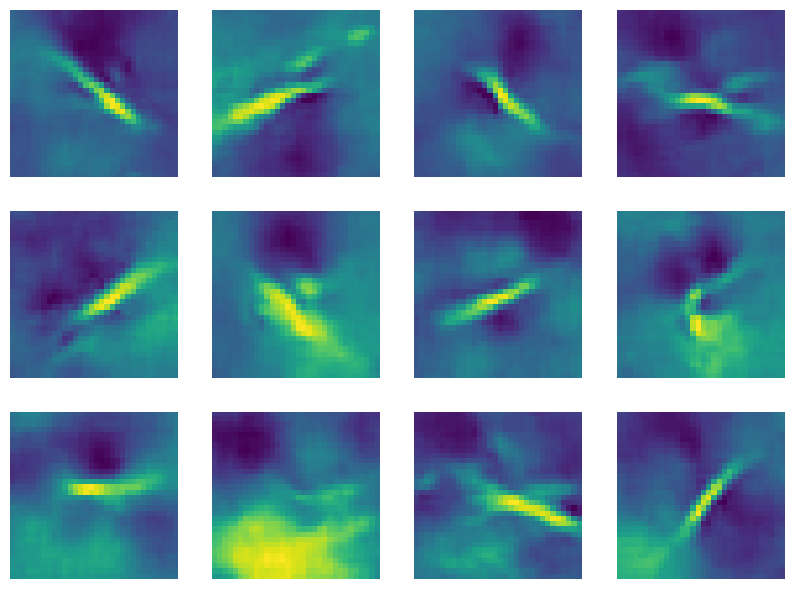

In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)
loss_logs_df_columns = ['epoch','loss_sum', 'reconstruction_loss', 'kl_loss']
loss_logs_df=pd.DataFrame(columns=loss_logs_df_columns)
loss_logs_df_train_columns = ['epoch','reconstruction_loss', 'kl_loss']
loss_logs_df_train=pd.DataFrame(columns=loss_logs_df_train_columns)
best_rec_valid = float('inf')
best_kl_valid = float('inf')

for epoch in range(1, epochs + 1):
    loss_list_train = []
    loss_train, rec_train, kl_train = 0, 0, 0
    for train_x in train_dataset:
        r_loss, kl_loss = compute_apply_gradients(model, train_x, optimizer)
        rec_train += r_loss
        kl_train += kl_loss

    # Calculate average training losses for the epoch
    num_batches = len(train_dataset)
    avg_rec_train = rec_train / num_batches
    avg_kl_train = kl_train / num_batches
    loss_list_train.append({'epoch': epoch,'reconstruction_loss': avg_rec_train, 'kl_loss': avg_kl_train})

    # Append to the training logs DataFrame
    loss_logs_df_train = pd.concat([loss_logs_df_train, pd.DataFrame(loss_list_train)], ignore_index=True)
    print('Epoch: {}, reconstruction_loss: {}, kl_loss: {}'
  .format(epoch, avg_rec_train, avg_kl_train))

    losslist = []
    loss_valid,rec_valid,kl_valid=0,0,0
    for test_x in test_dataset:
        loss_batchLoss, rec_batchLoss, kl_batchLoss = compute_loss(model, test_x)
        loss_valid+=loss_batchLoss
        rec_valid+=rec_batchLoss
        kl_valid+=kl_batchLoss
    len_test=len(test_dataset)
    loss_valid,rec_valid,kl_valid=loss_valid/len_test,rec_valid/len_test,kl_valid/len_test
    losslist.append({'epoch': epoch,'loss_sum':loss_valid,'reconstruction_loss':rec_valid,'kl_loss':kl_valid})#append loss to list

    # display.clear_output(wait=False)
    ## Look at tapas and correct this
    loss_logs_df = pd.concat([loss_logs_df, pd.DataFrame(losslist)], ignore_index=True)
    print('Epoch: {}, Test set LOSS_sum: {}, reconstruction_loss: {}, kl_loss: {}'
  .format(epoch, loss_valid, rec_valid, kl_valid))
    # Checkpoint model if both metrics improved
    if rec_valid < best_rec_valid :
        best_rec_valid = rec_valid
        best_kl_valid = kl_valid
        model.save_weights('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/my_model_weights_new_Nocactus_2.h5')
        print('Checkpoint saved at Epoch {}: Improved reconstruction_loss and kl_loss.'.format(epoch))
    if epoch%10==0:
      generate_and_save_images(
          model, epoch, random_vector_for_generation)
loss_logs_df.to_csv('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/loss_logs_df_valid_new_Nocactus_2.csv', index=False)
loss_logs_df_train.to_csv('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/loss_logs_df_train_new_Nocactus_2.csv', index=False)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/images/image_at_epoch_new_Nocactus_2{:04d}.png'.format(epoch_no))

(-0.5, 999.5, 999.5, -0.5)

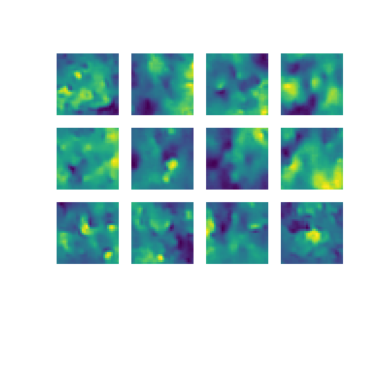

In [ ]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

In [ ]:
model.built = True
model.load_weights("/content/drive/MyDrive/AML/Challenge1/dataset/VAE_Training/my_model_weights_new_Nocactus_2.h5")

In [ ]:
epoch=100

tf.Tensor(46.584892, shape=(), dtype=float32) tf.Tensor(31.864307, shape=(), dtype=float32) tf.Tensor(14.720583, shape=(), dtype=float32)


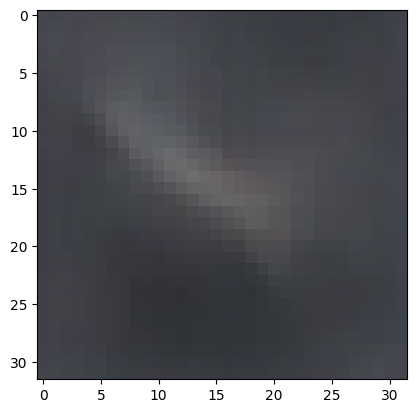

In [ ]:
# test_inputs =test_images[0]
test_inputs =test_images[8]
test_inputs = test_inputs.reshape(1,32,32,3)

# from tf.keras.models import load_model

def check_image(test_inputs,latent_dim):
    encod, logvar = model.encode(test_inputs)
    repar = model.reparameterize(encod, logvar)
    img = model.decode(repar)
    loss_sum, recon_loss, kl_loss, = compute_loss(model, test_inputs)
    print(loss_sum, recon_loss ,kl_loss)
    img = np.squeeze(img)
    return plt.imshow(img)

img = check_image(test_inputs,128)

tf.Tensor(52.737274, shape=(), dtype=float32) tf.Tensor(39.210648, shape=(), dtype=float32) tf.Tensor(13.5266285, shape=(), dtype=float32)


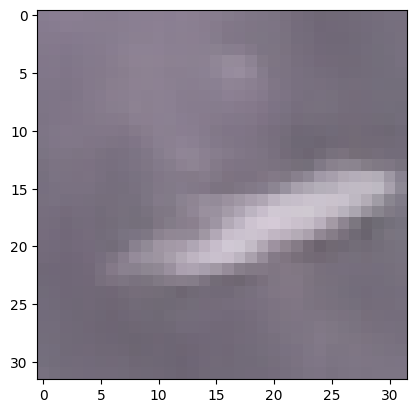

In [ ]:
# test_inputs =test_images[0]
test_inputs =test_images[40]

# from tf.keras.models import load_model

def check_image(test_inputs):
    test_inputs = test_inputs.reshape(1,32,32,3)
    loaded_model = model
    encod, logvar = loaded_model.encode(test_inputs)
    repar = loaded_model.reparameterize(encod, logvar)
    img = loaded_model.decode(repar)
    loss_sum, recon_loss, kl_loss, = compute_loss(loaded_model, test_inputs)
    print(loss_sum, recon_loss ,kl_loss)
    img = np.squeeze(img)
    return img

reconstrcuted_img_with_cactus=check_image(test_inputs)
plt.imshow(reconstrcuted_img_with_cactus)

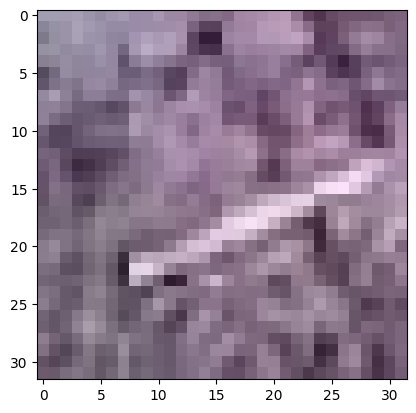

In [ ]:
plt.imshow(test_images[40])

In [ ]:
original_img_with_cactus=test_images[40]
original_img_with_Nocactus=images_0[10]

In [ ]:
original_img_with_cactus
reconstrcuted_img_with_cactus
original_img_with_Nocactus
reconstrcuted_img_with_Nocactus

tf.Tensor(25.823105, shape=(), dtype=float32) tf.Tensor(12.703868, shape=(), dtype=float32) tf.Tensor(13.119238, shape=(), dtype=float32)


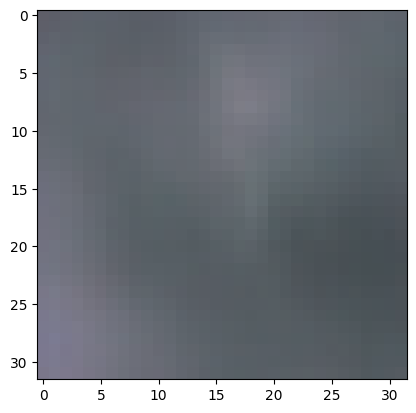

In [ ]:
# test_inputs =test_images[0]
test_inputs =images_0[10]

# from tf.keras.models import load_model

def check_image(test_inputs):
    test_inputs = test_inputs.reshape(1,32,32,3)
    loaded_model = model
    encod, logvar = loaded_model.encode(test_inputs)
    repar = loaded_model.reparameterize(encod, logvar)
    img = loaded_model.decode(repar)
    loss_sum, recon_loss, kl_loss, = compute_loss(loaded_model, test_inputs)
    print(loss_sum, recon_loss ,kl_loss)
    img = np.squeeze(img)
    return img

reconstrcuted_img_with_Nocactus=check_image(test_inputs)
plt.imshow(reconstrcuted_img_with_Nocactus)

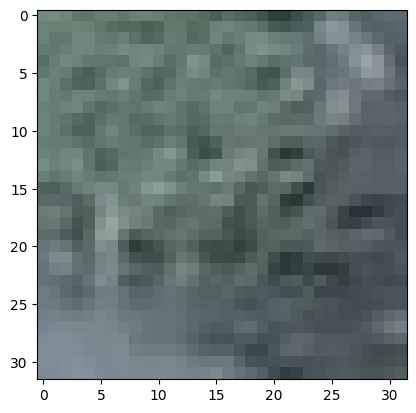

In [ ]:
plt.imshow(test_inputs)

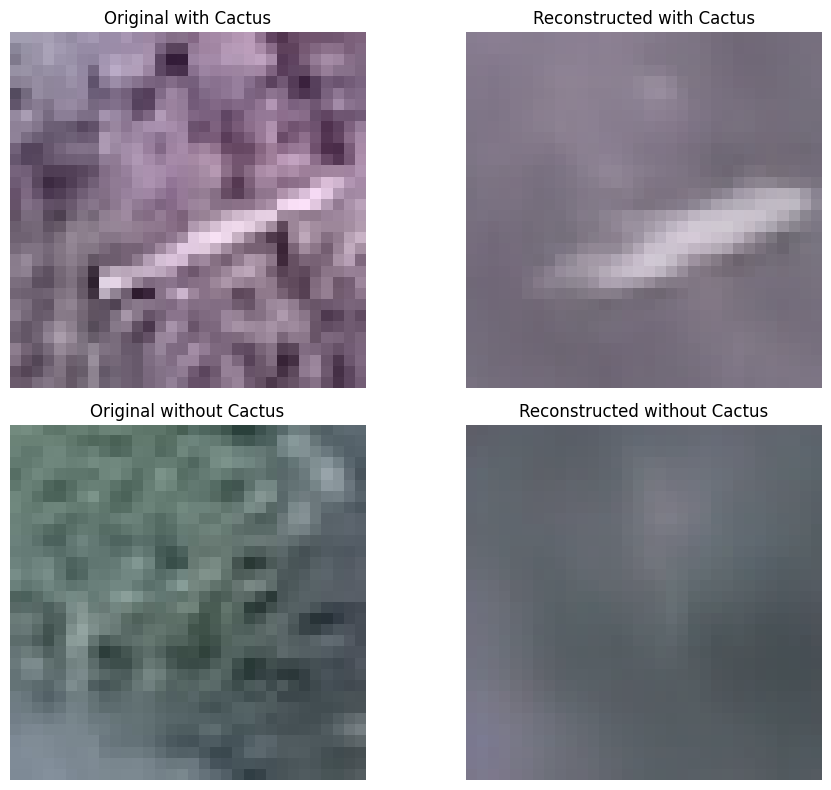

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot each image
axs[0, 0].imshow(original_img_with_cactus)
axs[0, 0].set_title("Original with Cactus")
axs[0, 0].axis('off')

axs[0, 1].imshow(reconstrcuted_img_with_cactus)
axs[0, 1].set_title("Reconstructed with Cactus")
axs[0, 1].axis('off')

axs[1, 0].imshow(original_img_with_Nocactus)
axs[1, 0].set_title("Original without Cactus")
axs[1, 0].axis('off')

axs[1, 1].imshow(reconstrcuted_img_with_Nocactus)
axs[1, 1].set_title("Reconstructed without Cactus")
axs[1, 1].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

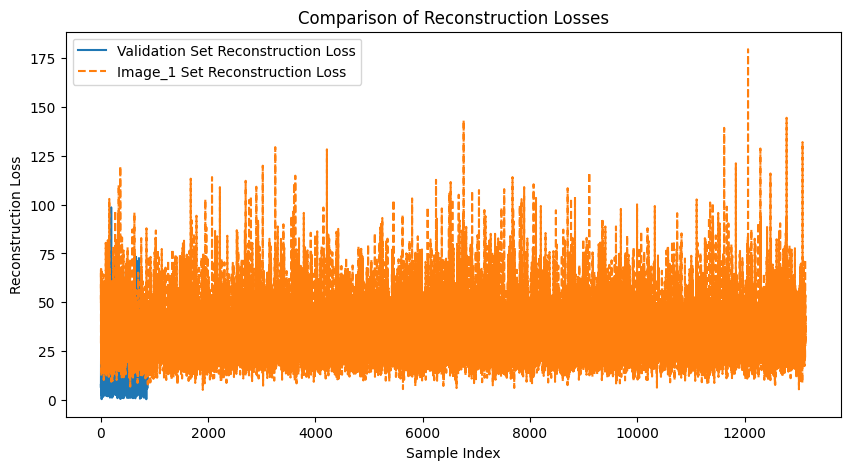

In [ ]:
import matplotlib.pyplot as plt

# Assuming `validation_dataset` and `image_0_dataset` are preprocessed and ready to use
recon_losses_validation = []
recon_losses_image_1 = []

# Compute reconstruction loss for the validation dataset
for test_inputs in test_images:
    test_inputs = test_inputs.reshape(1,32,32,3)
    _, recon_loss,_= compute_loss(model, test_inputs)
    recon_losses_validation.append(recon_loss.numpy())

# Compute reconstruction loss for the image_0 dataset
for test_inputs in images_1:
    test_inputs = test_inputs.reshape(1,32,32,3)
    _, recon_loss,_ = compute_loss(model, test_inputs)
    recon_losses_image_1.append(recon_loss.numpy())

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(recon_losses_validation, label='Validation Set Reconstruction Loss')
plt.plot(recon_losses_image_1, label='Image_1 Set Reconstruction Loss', linestyle='--')
plt.title('Comparison of Reconstruction Losses')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()


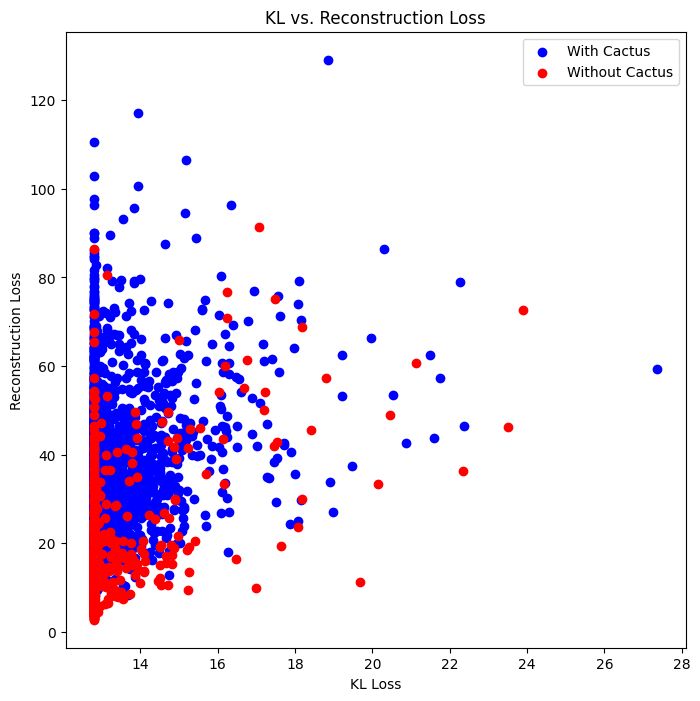

In [ ]:
import matplotlib.pyplot as plt

# Assuming `test_images` and `images_0` are preprocessed and ready to use
recon_losses_validation = []
kl_losses_validation = []
recon_losses_image_1 = []
kl_losses_image_1 = []

# Compute reconstruction and KL loss for the validation dataset
for test_inputs in test_images:
    test_inputs = test_inputs.reshape(1, 32, 32, 3)
    loss_sum, recon_loss, kl_loss = compute_loss(model, test_inputs)
    recon_losses_validation.append(recon_loss.numpy())
    kl_losses_validation.append(kl_loss.numpy())

# Compute reconstruction and KL loss for the image_0 dataset
for test_inputs in images_0:
    test_inputs = test_inputs.reshape(1, 32, 32, 3)
    loss_sum, recon_loss, kl_loss = compute_loss(model, test_inputs)
    recon_losses_image_1.append(recon_loss.numpy())
    kl_losses_image_1.append(kl_loss.numpy())

# Plotting the results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x=kl_losses_validation, y=recon_losses_validation, color='b', label='With Cactus')
ax.scatter(x=kl_losses_image_1, y=recon_losses_image_1, color='r', label='Without Cactus')
plt.title('KL vs. Reconstruction Loss')
plt.xlabel('KL Loss')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()


In [ ]:
# Calculate mean and standard deviation for validation dataset
mean_validation = np.mean(recon_losses_validation)
std_dev_validation = np.std(recon_losses_validation)

# Calculate mean and standard deviation for image_0 dataset
mean_image_1 = np.mean(recon_losses_image_1)
std_dev_image_1 = np.std(recon_losses_image_1)

# Print the calculated statistics
print(f"Validation Set - Mean Reconstruction Loss: {mean_validation}, Standard Deviation: {std_dev_validation}")
print(f"Image_1 Set - Mean Reconstruction Loss: {mean_image_1}, Standard Deviation: {std_dev_image_1}")


Validation Set - Mean Reconstruction Loss: 34.6847038269043, Standard Deviation: 14.934501647949219
Image_1 Set - Mean Reconstruction Loss: 19.450828552246094, Standard Deviation: 14.265223503112793


In [ ]:
import pandas as pd

def classify_images_based_on_threshold(dataset, model, threshold, label):
    # List to hold reconstruction losses and predictions
    losses = []
    predictions = []

    # Compute reconstruction loss for the dataset
    for idx, test_inputs in enumerate(dataset):
        test_inputs = test_inputs.reshape(1,32,32,3)
        _, recon_loss,_ = compute_loss(model, test_inputs)
        recon_loss_value = recon_loss.numpy()
        losses.append((idx, recon_loss_value))

        # Classify based on the threshold
        if recon_loss_value > threshold:
            predictions.append((idx, label, 0))  # Predicted as no cactus
        else:
            predictions.append((idx, label, 1))  # Predicted as cactus

    return predictions, losses

# Parameters
threshold = 20

# Classify both datasets
predictions_image_1, losses_image_1 = classify_images_based_on_threshold(images_1,model, threshold, 0)
predictions_validation, losses_validation = classify_images_based_on_threshold(test_images, model, threshold, 1)

# Combine predictions
all_predictions = predictions_image_1 + predictions_validation

# Create DataFrame
df_predictions = pd.DataFrame(all_predictions, columns=['Image Index', 'Actual Class', 'Predicted Class'])
df_predictions


KeyboardInterrupt: 

In [ ]:
import pandas as pd

def compute_reconstruction_losses(dataset, model):
    losses = []
    for idx, test_inputs in enumerate(dataset):
        test_inputs = test_inputs.reshape(1, 32, 32, 3)  # Ensure input shape matches model's expected input
        _, recon_loss, _ = compute_loss(model, test_inputs)
        recon_loss_value = recon_loss.numpy()
        losses.append((idx, recon_loss_value))
    return losses

def classify_based_on_threshold(losses, threshold, label):
    predictions = []
    for idx, recon_loss_value in losses:
        if recon_loss_value > threshold:
            predictions.append((idx, label, 1))  # Predicted as no cactus
        else:
            predictions.append((idx, label, 0))  # Predicted as cactus
    return predictions

# Compute losses for both datasets
# losses_image_1 = compute_reconstruction_losses(images_0, model)
# losses_validation = compute_reconstruction_losses(test_images, model)

In [ ]:
# Set the threshold for classification
threshold = 24

# Classify based on the threshold
predictions_image_1 = classify_based_on_threshold(losses_image_1, threshold, 0)
predictions_validation = classify_based_on_threshold(losses_validation, threshold, 1)

# Combine predictions and create a DataFrame
all_predictions = predictions_image_1 + predictions_validation
df_predictions = pd.DataFrame(all_predictions, columns=['Image Index', 'Actual Class', 'Predicted Class'])

df_predictions


,Image Index,Actual Class,Predicted Class
0,0,0,1
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
6987,2623,1,1
6988,2624,1,1
6989,2625,1,1
6990,2626,1,0


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Extract predictions and actual classes
actual_classes = df_predictions['Actual Class'].values
predicted_classes = df_predictions['Predicted Class'].values

# Calculate metrics
accuracy = accuracy_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7521453089244852
Recall: 0.7568493150684932
F1 Score: 0.6965505165470145


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      4364
           1       0.65      0.76      0.70      2628

    accuracy                           0.75      6992
   macro avg       0.74      0.75      0.74      6992
weighted avg       0.76      0.75      0.76      6992



In [ ]:
print(len(test_images))
print(len(images_1))

873
13136


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc_valid = matthews_corrcoef(actual_classes, predicted_classes)
# mcc_test = matthews_corrcoef(ground_truths_test, class_predictions_test)
print(f"Matthews Correlation Coefficient:  Validation {mcc_valid}")

Matthews Correlation Coefficient:  Validation 0.38820579642697034


In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_valid = balanced_accuracy_score(actual_classes, predicted_classes)
# balanced_accuracy_test = balanced_accuracy_score(ground_truths_test, class_predictions_test)

print(f"Balanced Accuracy: Valid {balanced_accuracy_valid}")

Balanced Accuracy: Valid 0.8154718615579302
